<a href="https://colab.research.google.com/github/takotab/gas-predictor/blob/seq-fastai/notebooks/_v2_seq_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip3 install torch torchvision -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu92/torchvision-0.4.2%2Bcu92-cp36-cp36m-linux_x86_64.whl
ERROR: torchvision 0.4.2+cu92 has requirement torch==1.3.1, but you'll have torch 1.0.0 which is incompatible.
ERROR: Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/usr/local/lib/python3.6/site-packages/torchvision-0.4.2+cu92.dist-info'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
!pip install git+https://github.com/fastai/fastai2

  Cloning https://github.com/fastai/fastai2 to /tmp/pip-req-build-5ueb9ofc
  Running command git clone -q https://github.com/fastai/fastai2 /tmp/pip-req-build-5ueb9ofc
  Created wheel for fastai2: filename=fastai2-0.0.1-cp37-none-any.whl size=167328 sha256=7fcf545e55a66e8b9f0ee6078043fc3ea555c81aaed245ce9ce30589c4d88dee
  Stored in directory: /tmp/pip-ephem-wheel-cache-fon4cigo/wheels/a1/59/9a/50335b36924b827e29d5f40b41fc3a008cc1f30dd80e560dfd
Successfully built fastai2


In [2]:
import fastai2

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import os
import sys
# sys.path.append('..')
# from pathlib import Path
import pandas as pd
import datetime as dt
import numpy as np
from tqdm import tqdm_notebook as tqdm
import seaborn as sns

/home/tako/devtools/fastai_dev/env/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/tako/devtools/fastai_dev/env/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
from fastai2.test import *
from fastai2.core import *
from fastai2.layers import *
from fastai2.data.all import *
from fastai2.optimizer import *
from fastai2.learner import *
from fastai2.metrics import *
from fastai2.text.core import *
from fastai2.text.data import *
from fastai2.text.models.core import *
from fastai2.text.models.awdlstm import *
from fastai2.callback.rnn import *
from fastai2.callback.all import *

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def plot_days(data, ax=None, left=None, right=None, figsize = None,title=None, spacing=.1,  **kwargs):
    from pandas import plotting
    figsize = ifnone(figsize,(20,10))
    if ax is None: _,ax = plt.subplots(figsize=figsize)           
    colors = getattr(getattr(plotting, '_matplotlib').style, '_get_standard_colors')(num_colors=len(left)+len(right))
    for c in left+right:
        if c not in data:
            print(f'Warning{c} not in {data.columns}')
    # First axis
    ax = data.loc[:, left].plot(label=left, color=colors[:len(left)],ax = ax, **kwargs)
    ax.set_ylabel(ylabel=left)
    lines, labels = ax.get_legend_handles_labels()

    for n in range(len(right)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, right[n]].plot(ax=ax_new, label=right[n], color=colors[len(left)+n % len(colors)],**kwargs)
        ax_new.set_ylabel(ylabel=right[n])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    if title is not None: ax.set_title(title)
    return ax

In [15]:
from copy import copy 
class Days(CollBase, GetAttr, FilteredBase):
    def __init__(self,df, y_names, cat_var, con_var):
        self.cat_var, self.con_var, self.y_names = cat_var, con_var, y_names                    
        self.df = df
        self.df.set_index('datetime',drop=False,inplace=True)  
        self.cols = ['datetime']+self.con_var+self.cat_var
        self.cats = dict(self.df[self.cat_var].iloc[0])
        for c in self.cols+self.y_names:
            if c not in self.df.columns:
                print(f'Warning {c} not in {self.df.columns}')
                
    def __repr__(self):
        return str(self.df)
    
    def copy(self):
        # https://stackoverflow.com/questions/17591104/in-pandas-can-i-deeply-copy-a-dataframe-including-its-index-and-column        
        return Days(pd.DataFrame(self.df.values.copy(), self.df.index.copy(), self.df.columns.copy()),self.y_names,self.cat_var,self.con_var)
    
    def repr(self):
        return {'y_names':self.y_names,'cat_var':self.cat_var,'con_var': self.con_var }
    
    def show(self,plot=True,**kwargs):
        title= f"{self.df['loc'][0]} ({self.df['city'][0]}) from {str(min(self.df.loc[:,'datetime']))} to {str(max(self.df.loc[:,'datetime']))} #{self.df.shape[0]}"

        if plot:
            plot_days(self.df,left=self.y_names+['pred'],right=self.con_var,title=title,**kwargs)
        else:
            return title+'\n'+str(self.df.head(1)   ) 
            
    @classmethod
    def from_intervals(cls,intervals,seq_len,y_names, cat_var, con_var):
        
        cls(_df, y_names, cat_var, con_var)
    

In [16]:
d = Days(pd.DataFrame({'datetime':[pd.Timestamp('2019-01-01')+x*pd.Timedelta('1H') for x in range(24)],
                       'target':np.arange(24),'con':np.arange(24)-2,
                       'cat':[1]*24
                      }),['target'],['cat'],['con'])
_d = d.copy()
d.df['con'] += 4
test_ne(d.df['con'].values,_d.df['con'].values)
d.cats

{'cat': 1}

CPU times: user 5.5 ms, sys: 621 µs, total: 6.12 ms
Wall time: 5.8 ms
Warningpred not in Index(['datetime', 'target', 'temp', 'pressure', 'humidity', 'loc', 'city'], dtype='object')


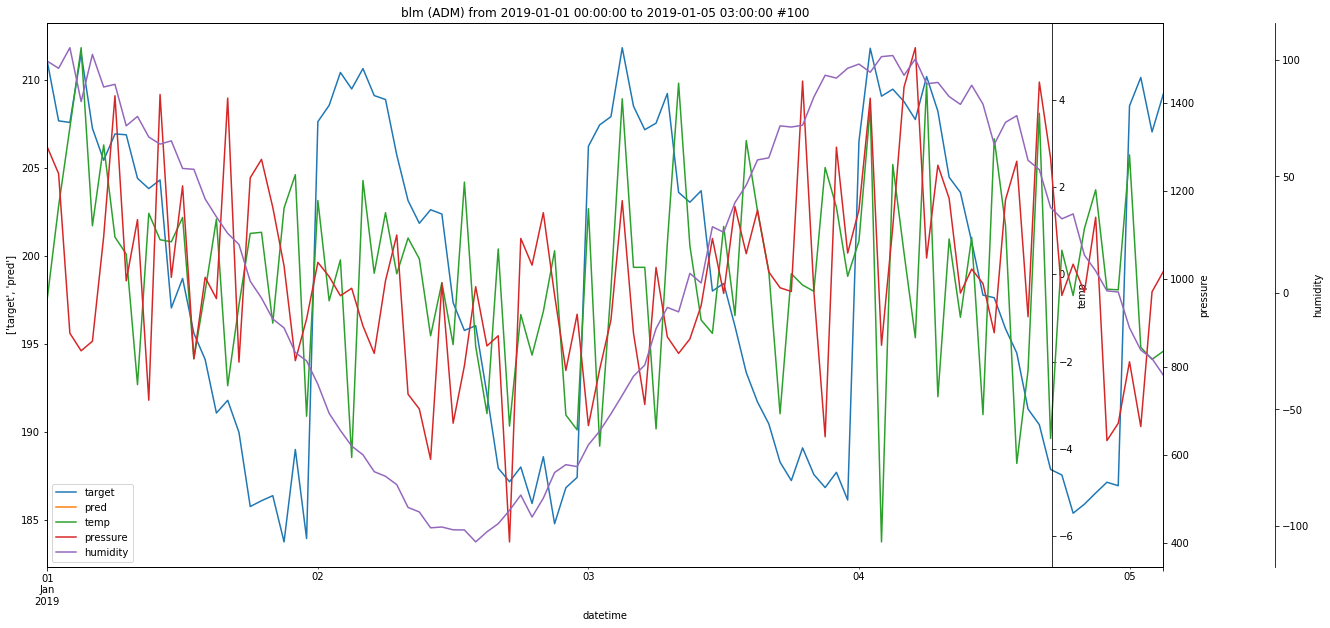

In [17]:
def make_fake_data(num, l=None, locations = 4, jumps = True, chance_of_jump = 0.9):
    locs,citys = ['blm','cnt','rzb','ctl'],['ADM','ADM','ADM','RTD']
    loc_multis = [198,587,999,1660]
    dfs = []
    for i_loc in range(locations):
        loc,city,loc_multi = locs[i_loc], citys[i_loc],loc_multis[i_loc]
        start = pd.Timestamp('2019-01-01')
        for i in range(num):
            l = ifnone(l,100)
            t = i + np.arange(l)/12
            t_dt = [start+pd.Timedelta(hours=x) for x in range(l)]
            _df = pd.DataFrame(data={'datetime':t_dt,
                                'target': loc_multi + np.random.randn(l)*1.5 + 3*np.sin([o.hour/12*3.15 for o in t_dt]) + 10*np.cos([(o.hour/24)*3.15 for o in t_dt]), 
#                                 'pred':np.random.randn(l) * .5 + np.sin(t),                                        
                                'temp':np.random.randn(l)*2+np.cos(t)+np.cos(-t/2),
                                'pressure':1000+100*(np.random.randn(l)*2+np.cos(-t)),
                                'humidity':np.random.randn(l)*5+np.cos(t)*100,
                                'loc':[loc]*l,
                                'city':[city]*l})
            assert _df.shape[0] == l
            dfs.append(_df)
            start += pd.Timedelta(hours=l)
            if np.random.rand()> chance_of_jump and jumps:
                start += pd.Timedelta(hours=l*3)   
                start+=(pd.Timedelta('1H')*np.random.choice(np.arange(24)))
            
    return pd.concat(dfs)
%time _df = make_fake_data(1,locations=1)
it = Days(_df,['target'],['loc','city'],['temp','pressure','humidity'])
it.show(figsize=(20,10))

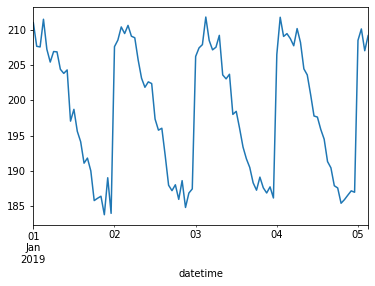

In [18]:
it.df['target'].plot()

In [19]:
df = make_fake_data(100,locations=4)
print(df.shape, min(df.datetime),max(df.datetime))
df.head()

(40000, 7) 2019-01-01 00:00:00 2020-08-09 10:00:00


,datetime,target,temp,pressure,humidity,loc,city
0,2019-01-01 00:00:00,208.925888,2.599625,1597.587510,93.784376,blm,ADM
1,2019-01-01 01:00:00,208.731794,2.770103,828.836130,107.861927,blm,ADM
2,2019-01-01 02:00:00,210.322421,6.045935,913.495831,98.341743,blm,ADM
3,2019-01-01 03:00:00,205.583276,5.791977,1094.417698,97.091276,blm,ADM
4,2019-01-01 04:00:00,209.816530,2.886039,1156.863908,102.729993,blm,ADM


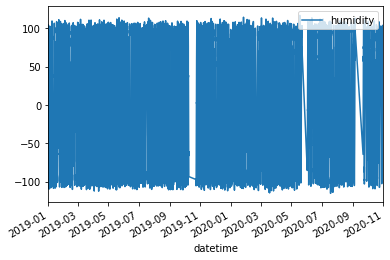

In [20]:
df = make_fake_data(100,locations=2,l=120,jumps=True)
df.index = df.datetime
df[['humidity']].plot()

In [21]:
from copy import copy
def to_elapsed(s):
    return s.astype(np.int64) // 10 ** 9

def remove_last(df,start, end, sz):
    old_start = copy(start)
    start = end - sz + pd.Timedelta(hours = 1)
    return df[start:end], old_start, start
    
def get_not_interval(df, interval, shift = 1):
    df.index = df.datetime
    df = df.sort_index()
    df["delta"] = abs(
        (to_elapsed(df["datetime"]) - to_elapsed(df["datetime"].shift(shift)))
    )
    #     df["delta"] = df['delta'].dt.seconds
    not_hour = df.index[df["delta"] != interval].tolist()
    del df["delta"]
    return not_hour
    

def make_interval(
    df: pd.DataFrame,
    interval=3600,
    sz='72H',
    max_splits=35,
    callback_error=None,
) -> pd.DataFrame:
    """Will check if `df.datetime` has interval of `interval` in seconds. 
    
    if not will make it happen and return a list where this is done.
    """
    starts = get_not_interval(df, interval, 1)
    ends = get_not_interval(df, interval, -1)
    dfs = []
    for start, end in zip(starts,ends):        
        dfs += [df.loc[i:i+pd.Timedelta(sz),:] for i in pd.date_range(start,end,freq=sz) ]       

    return dfs

dfs = []
for l in set(df['loc']):  
    _df = df[df['loc'] == l]  
    dfs += L(make_interval(_df)).map(lambda x: Days(x, ['target'], ['city','loc'], ['temp','pressure','humidity']))
lengths =pd.DataFrame({'rows':[dfs[i].df.shape[0] for i in range(len(dfs))]})

In [22]:
[(dfs[i].df, i) for i in range(len(dfs)) if dfs[i].df.isnull().sum().sum()>0]

[]

In [23]:
pd.value_counts(lengths['rows'])

73    322
24      8
48      7
72      4
Name: rows, dtype: int64

In [24]:
df = make_fake_data(100,locations=4,l=100,jumps=True)
items = []
for l in set(df['loc']):  
    _df = df[df['loc'] == l]  
    items += L(make_interval(_df)).map(lambda x: Days(x, ['target'], ['city','loc'], ['temp','pressure','humidity']))
    

In [25]:
print('\n'.join([d.show(plot=False) for d in items[[0,-1]][::-1]]))

blm (ADM) from 2020-06-27 08:00:00 to 2020-06-29 23:00:00 #64
                               datetime      target      temp     pressure  \
datetime                                                                     
2020-06-27 08:00:00 2020-06-27 08:00:00  207.062747 -1.533304  1173.913423   

                     humidity  loc city  
datetime                                 
2020-06-27 08:00:00  5.941372  blm  ADM  
rzb (ADM) from 2019-01-01 00:00:00 to 2019-01-04 00:00:00 #73
             datetime      target      temp    pressure    humidity  loc city
datetime                                                                     
2019-01-01 2019-01-01  1009.96863  4.042722  1100.30779  108.208876  rzb  ADM


In [26]:
def split_idxs(items):
    total = 0
    train_idx, valid_idx, test_idx = [], [], []
    train_idx_s, valid_idx_s, test_idx_s = 0,0,0
    for idx, it in enumerate(items):
        
        ts = it.df['datetime'].iloc[0]
        total += _df.shape[0]
        if  ts.month == 2       :
            if ts.minute == 0:
                test_idx.append(idx)
                test_idx_s += _df.shape[0]

        elif ts.month == 9 or ts.month == 10:
            if ts.minute == 0:
                valid_idx.append(idx)
                valid_idx_s += _df.shape[0]
        else:
            train_idx.append(idx)
            train_idx_s +=_df.shape[0]

    if len(valid_idx) == 0 and len(train_idx):
        valid_idx.append(train_idx.pop(-1))
    if len(test_idx) == 0 and len(train_idx):
        test_idx.append(train_idx.pop(-1))
    print()
    print("Test set length\t\t", test_idx_s / total, test_idx_s)
    print("Validation set length\t", valid_idx_s / total,valid_idx_s)
    print("Train set length\t", train_idx_s / total, train_idx_s)
    print(total, test_idx_s)
    
    return [train_idx, valid_idx, test_idx]

splits = split_idxs(items)


Test set length		 0.1001727115716753 580000
Validation set length	 0.11744386873920552 680000
Train set length	 0.7823834196891192 4530000
5790000 580000


In [27]:
def _to_elapsed(o:int):
    return o // 10 ** 9
def _to_dt(o):
    return o*(10**9)
pd.Timestamp(_to_dt(_to_elapsed(pd.Timestamp('2019-01-01').value)))

Timestamp('2019-01-01 00:00:00')

In [28]:

class Change_dt(Transform):
    def __init__(self, start=None, col='datetime'):
        self.start = ifnone(start, _to_elapsed(pd.Timestamp('2019-01-01').value))
        self.col = col
        
    def encodes(self, o:Days): 
        a = o.copy()
#         if set(o.df.loc[:,'city']) == {0}:
#             print('c dt in:',{c:set(o.df.loc[:,c]) for c in o.cat_var})
#             print(o.df)            
        a.df[self.col] = _to_elapsed(a.df[self.col].astype(int)) - self.start
        return a
    
    def decodes(self, o:Days): 
        o.df[self.col] = pd.to_datetime(_to_dt(o.df[self.col] + self.start))
        o.df.index = o.df[self.col]
        return o

In [29]:
_df = make_fake_data(1,locations=1)
it = Days(_df, ['target'],['loc','city'],['temp','pressure','humidity'])
Dt = Change_dt()
it = Dt(it) 
_ = Dt.decodes(it)
test_eq(it.df, Dt.decode(Dt(it)).df)

In [30]:
class TensorSequenceX(TensorBase):pass
class Numericalize(Transform):
    "Reversible transform of tokenized cat_var to numericalized ids"
    
    def setup(self, dsrc):
        if dsrc is None: return
        self.item = dsrc[0]
        self.vocab,self.o2i = {},{}
        for cat in self.item.cat_var:
            count = L()
            for i in [list(o.df[cat].unique()) for o in dsrc]:
                count.append(*i)
            self.o2i[cat] = {k:int(i) for i,k in enumerate(count.unique() + L(0))}            
            self.vocab[cat] = {v:k for k,v in self.o2i[cat].items()}

    def encodes(self, inp:Days):
        o = inp.copy()
        for c in self.item.cat_var:
            o.df.loc[:,c] = o.df.loc[:,c].map(self.o2i[c])
        o.df.loc[24:,self.item.y_names] = 0
        res = o.df.loc[:,self.item.cols].fillna(0).values
        
        a = TensorSequenceX(tensor(res))
#         print('Numericalize out :',torch.isnan(a).sum())
        return a
    
    def decodes(self, o:TensorSequenceX):         
        o = pd.DataFrame(o.numpy(),columns = self.item.cols )
        for c in self.item.cat_var:
            o[c] = o[c].map(self.vocab[c])
        return Days(o,**self.item.repr())
    
    def get_vocab_sz(self):
        return [len(self.vocab[v]) for v in self.item.cat_var]
    

In [378]:
df = make_fake_data(10,locations=3,l=73,jumps=False)
items = []
for l in set(df['loc']):  
    _df = df[df['loc'] == l]  
    items += L(make_interval(_df)).map(lambda x: Days(x, ['target'], ['city','loc'], ['temp','pressure','humidity']))    
num = Numericalize()
num.setup(items)
test_eq(len(num.vocab['loc']), len(set(df['loc']))+1)
test_eq(len(num.vocab['city']), len(set(df['city']))+1)
test_eq(num.get_vocab_sz(),(len(set(df['city']))+1, len(set(df['loc']))+1))

In [379]:
it = items[0].copy()
Dt = Change_dt()
_it = num(Dt(it))
test_eq(torch.isnan(_it).sum(),0)
df = Dt.decodes(num.decode(_it )).df
test_eq(df[it.cols],it.df[it.cols])

Warning target not in Index(['datetime', 'temp', 'pressure', 'humidity', 'city', 'loc'], dtype='object')


In [380]:
class TensorSequenceY(TensorBase):pass

class Label(Transform):    
    def setup(self, dsrc):
        if dsrc is None: return
        self.item = dsrc[0]
        
    def encodes(self, o:Days): 
        return TensorSequenceY(tensor(o.df[self.item.y_names].copy().values))
    
    def decodes(self, o:TensorSequenceY):         
        o = pd.DataFrame(o.numpy(),columns = self.item.y_names )
        return o
    

In [381]:
df = make_fake_data(10,locations=1,l=73,jumps=False)
items = []
for l in set(df['loc']):  
    _df = df[df['loc'] == l]  
    items += L(make_interval(_df)).map(lambda x: Days(x, ['target'], ['city','loc'], ['temp','pressure','humidity']))    
lab = Label()
lab.setup(items[:10])
test_eq(lab(items[1]).shape,(73,1))
test_eq(lab.decodes(lab(items[0])).shape, (73, 1))

In [382]:
class SeqLen(Transform):
    def __init__(self,len=73):
        self.len = len
        
    def encodes(self, o):   
        a = torch.zeros(self.len,o.shape[1])
        _len = min([self.len,o.shape[0]])
        a[:_len,:] = o[:_len,:]
        return a
    
    def decodes(self, o):
        return o
    

In [383]:
seqlen = SeqLen(73)
test_eq(seqlen(tensor(np.random.rand(50,3))).shape,(73,3))
test_eq(seqlen(tensor(np.random.rand(50,8))).shape,(73,8))

In [384]:
del seqlen
seqlen = SeqLen(10)
test_eq(seqlen(tensor(np.random.rand(50,3))).shape,(10,3))

In [385]:
class Normalize(Transform):   
    def __init__(self, norm_cols= None):
        self.norm_cols = norm_cols
        
    def setup(self, dsrc):
        if dsrc is None: return
        if self.norm_cols == None:
            self.norm_cols = range(dsrc[0].shape[-1])
        its = torch.cat([o[None,:,self.norm_cols] for o in dsrc])
        self.m,self.s = Tensor([0]*dsrc[0].shape[-1]),Tensor([1]*dsrc[0].shape[-1])
        self.m[self.norm_cols],self.s[self.norm_cols] = its.mean((0,1)),its.std((0,1))+1e-5
        
    def encodes(self, o):
        o = (o-self.m)/self.s
        return o
        
    
    def decodes(self, o):         
        o= (o*self.s)+self.m
        return o
    

In [386]:
a = np.array([[1+np.arange(7)]*73]*100)*(1+.3*np.random.randn(100,73,7))
# a[:,:,6] = 3.14
print(a.shape)
b = Tensor(a)
(b.mean((0,1)),b.std((0,1)))

(100, 73, 7)


(tensor([0.9986, 1.9936, 2.9920, 3.9661, 4.9784, 6.0117, 7.0170]),
 tensor([0.3016, 0.5952, 0.8984, 1.2113, 1.5157, 1.7826, 2.0742]))

In [387]:
norm = Normalize(range(6))
its = Tensor()
norm.setup([Tensor(a[i]) for i in range(a.shape[0])])
print(norm.m,norm.s)
test_close(norm.m, Tensor([1,2,3,4,5,6,0]),0.1)
test_close(norm.s,Tensor([.3,.6,.9,1.2,1.5,1.8,1]),0.1)

tensor([0.9986, 1.9936, 2.9920, 3.9661, 4.9784, 6.0117, 0.0000]) tensor([0.3016, 0.5952, 0.8984, 1.2113, 1.5157, 1.7826, 1.0000])


In [388]:
res = norm(Tensor(a))
test_close(res.mean((0,1)),Tensor([0]*6 + [7]),0.1)
test_close(res.std((0,1)),Tensor([1]*6+[2.1]),0.1)

In [389]:
a_res = norm.decodes(res)
test_close(a_res.mean((0,1)), Tensor([1,2,3,4,5,6,7]),0.1)
test_close(a_res.std((0,1)), Tensor([.3,.6,.9,1.2,1.5,1.8,2.1]),0.1)

In [390]:
df = make_fake_data(200,locations=4,l=210,jumps=True)
set(df['loc']),set(df['city'])

({'blm', 'cnt', 'ctl', 'rzb'}, {'ADM', 'RTD'})

In [391]:
items = []
for l in set(df['loc']):  
    _df = df[df['loc'] == l]  
    items += L(make_interval(_df)).map(lambda x: Days(x, ['target'], ['city','loc'], ['temp','pressure','humidity']))

In [392]:
items[0].df.head()
# {i: items[i].df.shape  for i in range(len(items)) if  set(items[i].df['loc']) == {np.nan}}

,datetime,target,temp,pressure,humidity,loc,city
datetime,,,,,,,
2019-01-01 00:00:00,2019-01-01 00:00:00,1668.603675,4.624483,1023.680380,93.420438,ctl,RTD
2019-01-01 01:00:00,2019-01-01 01:00:00,1672.752959,3.889250,1064.093342,100.347212,ctl,RTD
2019-01-01 02:00:00,2019-01-01 02:00:00,1669.526730,6.713477,1559.824018,94.106642,ctl,RTD
2019-01-01 03:00:00,2019-01-01 03:00:00,1670.541339,0.839050,1337.634926,103.136485,ctl,RTD
2019-01-01 04:00:00,2019-01-01 04:00:00,1672.543800,-1.872439,746.657734,100.180560,ctl,RTD


In [393]:
splits = split_idxs(items)


Test set length		 0.09137055837563451 9072000
Validation set length	 0.15355329949238578 15246000
Train set length	 0.7550761421319797 74970000
99288000 9072000


In [394]:
import warnings
warnings.filterwarnings('ignore')

In [395]:
bs,sl = 64,73
dsrc = DataSource(items.copy(), [[Change_dt(), Numericalize(),SeqLen(sl), Normalize(range(4))],
                          [Label(), SeqLen(sl)]
                         ],
                  splits=splits)

In [396]:
items[0].df.head()

,datetime,target,temp,pressure,humidity,loc,city
datetime,,,,,,,
2019-01-01 00:00:00,2019-01-01 00:00:00,1668.603675,4.624483,1023.680380,93.420438,ctl,RTD
2019-01-01 01:00:00,2019-01-01 01:00:00,1672.752959,3.889250,1064.093342,100.347212,ctl,RTD
2019-01-01 02:00:00,2019-01-01 02:00:00,1669.526730,6.713477,1559.824018,94.106642,ctl,RTD
2019-01-01 03:00:00,2019-01-01 03:00:00,1670.541339,0.839050,1337.634926,103.136485,ctl,RTD
2019-01-01 04:00:00,2019-01-01 04:00:00,1672.543800,-1.872439,746.657734,100.180560,ctl,RTD


In [397]:
dbch = dsrc.databunch(bs=bs, after_batch=[Cuda])
[o.shape for o in dbch.one_batch()]

[torch.Size([64, 73, 6]), torch.Size([64, 73, 1])]

In [398]:
def emb_sz_rule(n_cat): 
    "Rule of thumb to pick embedding size corresponding to `n_cat`"
    return min(600, round(1.6 * n_cat**0.56))

def _one_emb_sz(classes, n, sz_dict=None):
    "Pick an embedding size for `n` depending on `classes` if not given in `sz_dict`."
    sz_dict = ifnone(sz_dict, {})
    n_cat = len(classes[n])
    sz = sz_dict.get(n, int(emb_sz_rule(n_cat)))  # rule of thumb
    return n_cat,sz

def get_emb_sz(to, sz_dict=None):
    "Get default embedding size from `TabularPreprocessor` `proc` or the ones in `sz_dict`"
    return [_one_emb_sz(to.procs.classes, n, sz_dict) for n in to.cat_names]

In [399]:
print(dbch.tfms[0][1].vocab)
emb_sz = [(n,emb_sz_rule(n)) for n in dbch.tfms[0][1].get_vocab_sz()]
print(emb_sz)

{'city': {0: 'RTD', 1: 'ADM', 2: 0}, 'loc': {0: 'ctl', 1: 'cnt', 2: 'blm', 3: 'rzb', 4: 0}}
[(3, 3), (5, 4)]


In [424]:
class LSTM(Module):
    initrange=0.1

    def __init__(self, emb_szs, n_in, n_hid, n_layers,n_out):
        store_attr(self, 'emb_szs,n_hid,n_layers')
        # not going to use embeddings for now
#         self.emb = [nn.Embedding(emb_sz[0], emb_sz[1]) for emb_sz in emb_szs ]
        self.emb = nn.Embedding(4,1)
        self.bn = nn.BatchNorm1d(n_in)
        self.bn.bias.data.fill_(1e-3)
        self.bn.weight.data.fill_(1)
        self.bn2 = nn.BatchNorm1d(n_hid)
        self.w_rnn = nn.Parameter(Tensor([0]*n_out))
        self.w_in = nn.Parameter(Tensor([1]*n_in))
        input_sz = n_in # + np.sum([emb_sz[0] for emb_sz in emb_szs ])
        self.rnn = nn.LSTM(input_sz, n_hid, n_layers-1, batch_first=True)         
        self.last_layer = nn.Conv1d(n_hid, n_out, 1)
        self.out=[]
        
    def forward(self, x):
        print(x[0,0,-1],x[0,0,-2])
        x = self.bn(x.transpose(1,2)).transpose(1,2)
        raw_output = self.rnn(x)[0].transpose(1,2)
        raw_output = self.bn2(raw_output)
        o = raw_output.cpu().detach().numpy()
        self.out.append({'mean':np.float(o.mean()),'std':np.float(o.std())})
        o = self.last_layer(raw_output).transpose(1,2)
#         print(self.emb(x[:,0,-2].long()))
        return o  

mdl = LSTM(emb_sz, 6, 8, 2, 1).to(device)
b = dbch.one_batch()
out = mdl(b[0])
print(out.shape)


RuntimeError: CUDA error: device-side assert triggered

In [420]:
[o for o in mdl.out]

[{'mean': 1.7963044385282956e-08, 'std': 0.9998042583465576}]

In [402]:
learn = Learner(dbch, LSTM(emb_sz, 6, 8, 2, 1), loss_func=mse, opt_func=RAdam, metrics=[mae])

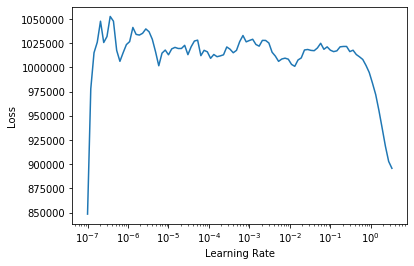

In [403]:
learn.lr_find()

In [404]:
learn.out = []

In [405]:
learn.fit_one_cycle(3, 5e-2)

epoch,train_loss,valid_loss,mae,time
0,6432153.500000,6134953.500000,2299.138184,00:06
1,5908270.500000,5219294.000000,2212.438965,00:06
2,5447599.500000,4934487.500000,2147.846680,00:06


In [406]:
a = learn.validate()

In [407]:
df = pd.DataFrame(learn.model.out)

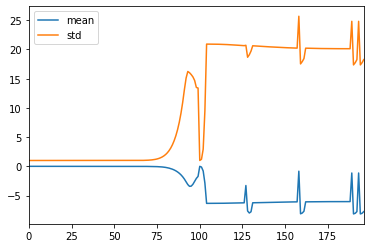

In [408]:
df.plot()

Warning target not in Index(['datetime', 'temp', 'pressure', 'humidity', 'city', 'loc'], dtype='object')


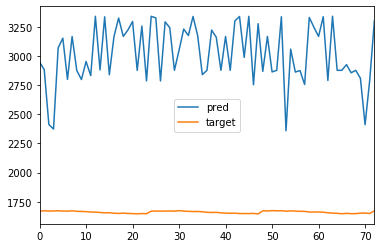

In [409]:
def plot_results(item_nm=0):
    y_hat = learn.predict(items[item_nm])
    df = pd.DataFrame({'pred':y_hat[0].values[:,0],'target':items[item_nm].df['target'].values,})
    df.plot()
plot_results()

Warning target not in Index(['datetime', 'temp', 'pressure', 'humidity', 'city', 'loc'], dtype='object')
Warning target not in Index(['datetime', 'temp', 'pressure', 'humidity', 'city', 'loc'], dtype='object')
Warning target not in Index(['datetime', 'temp', 'pressure', 'humidity', 'city', 'loc'], dtype='object')


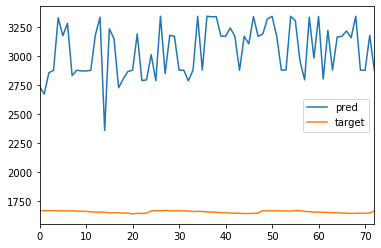

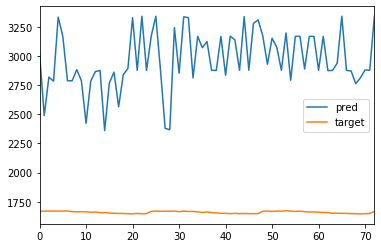

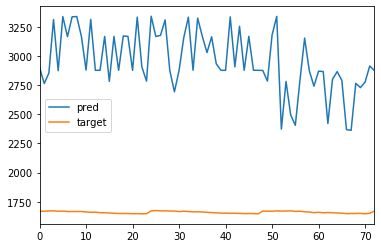

In [410]:
plot_results(1)
plot_results(2)
plot_results(3)